# Merge Fors2, Galex and Kids and write it in h5file


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023-06-12
- update : 2023-06-12


From this mergin work on spectra and photometry can start

In [1]:
import h5py
import pandas as pd
import numpy as np
import os
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [3]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info

# Read Fors2

In [4]:
input_file_h5  = '../data/FORS2spectra.hdf5'
output_file_h5  = '../data/FORS2spectraGalexKidsPhotom.hdf5'

In [5]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [6]:
df_info = ReadFors2h5FileAttributes(hf)

In [7]:
df_info.reset_index(drop=True, inplace=True) 

In [8]:
df_info

,num,name,ra,dec,Rmag,redshift,lines,RT,RV,eRV,Nsp
0,2,SPEC2,13.52997,-28.44776,21.18,0.34555,"b'K,H,G,H{beta} ...",12.3,103665,40,1
1,3,SPEC3,13.52552,-28.42080,21.45,0.68660,"b'[OII],H9,K,H,H{beta},[OIII],H8 ...",11.6,210642,48,4
2,9,SPEC9,13.50219,-28.40641,21.60,0.29266,"b'H9,H8,K,H ...",13.1,87798,58,1
3,13,SPEC13,13.49261,-28.38272,23.14,0.68870,"b'[OII],H{epsilon},H{delta},H{beta} ...",0.0,206610,0,1
4,19,SPEC19,13.60758,-28.43452,21.70,0.48395,"b'H10,H9,H8,K,H,H{delta} ...",7.1,145185,104,1
...,...,...,...,...,...,...,...,...,...,...,...
545,734,SPEC734,13.68083,-28.23290,0.00,0.23012,"b'[OII],H9,K,H,H{alpha},NII ...",7.2,69036,71,1
546,735,SPEC735,13.69958,-28.23161,19.28,0.36169,"b'K,H,G,H{beta} ...",8.2,108507,107,1
547,736,SPEC736,13.66431,-28.22849,21.64,0.55777,"b'[OII],H9,H{beta},[OIII] ...",10.5,167331,31,1
548,737,SPEC737,13.62722,-28.22692,21.40,0.52001,"b'[OII],K,H ...",10.2,156003,53,1


### Get Spectra

In [9]:
df_info_num = df_info["num"].values
key_tags = [ f"SPEC{num}" for num in df_info_num ]

In [10]:
all_df = []   
idx=0
for key in key_tags :
    group = hf.get(key)
    df = pd.DataFrame()
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
    all_df.append(df)
    idx+=1

# Get merged catalogs

- Be sure to use MAST results for Galex

In [11]:
catalog_galex_filename = "../data/results_crossmathcatalogs/info_fors2GALEX_frommast_crossmatch.csv"
catalog_kids_filename = "../data/results_crossmathcatalogs/info_fors2Kidscrossmatch_z-sel.csv"

In [12]:
df_info_galex = pd.read_csv(catalog_galex_filename,index_col=0)

In [13]:
df_info_galex.rename(columns={"angularsep":"asep_galex"},inplace=True)

In [14]:
df_info_galex

,num,ra,dec,Rmag,redshift,ra_galex,dec_galex,fuv_mag,nuv_mag,fuv_magerr,nuv_magerr,fuv_flux,nuv_flux,fuv_fluxerr,nuv_fluxerr,asep_galex
0,2,13.52997,-28.44776,21.18,0.34555,13.531423,-28.456012,20.422865,21.145170,0.252426,0.255224,24.595520,12.645368,5.716900,2.971828,30.060347
1,3,13.52552,-28.42080,21.45,0.68660,13.524429,-28.415100,NaN,22.173336,NaN,0.472773,NaN,4.905293,NaN,2.135443,20.808473
2,9,13.50219,-28.40641,21.60,0.29266,13.493582,-28.404687,NaN,21.510794,NaN,0.360429,NaN,9.029878,NaN,2.996898,27.954317
3,13,13.49261,-28.38272,23.14,0.68870,13.488292,-28.374033,NaN,22.629692,NaN,0.543497,NaN,3.221977,NaN,1.612464,34.131891
4,19,13.60758,-28.43452,21.70,0.48395,13.602319,-28.443209,NaN,21.152737,NaN,0.287115,NaN,12.557550,NaN,3.319950,35.437832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.00,0.23012,13.672907,-28.231896,19.537182,16.488522,0.154001,0.022848,55.606922,921.703300,7.885356,19.391645,25.387088
546,735,13.69958,-28.23161,19.28,0.36169,13.687228,-28.226752,20.512026,20.175917,0.277843,0.297318,22.656444,30.876852,5.796451,8.453250,42.903491
547,736,13.66431,-28.22849,21.64,0.55777,13.672907,-28.231896,19.537182,16.488522,0.154001,0.022848,55.606922,921.703300,7.885356,19.391645,29.898930
548,737,13.62722,-28.22692,21.40,0.52001,13.628613,-28.230257,21.295267,21.704386,0.383258,0.396922,11.012729,7.555190,3.886483,2.761346,12.801767


In [15]:
df_info_kids = pd.read_csv(catalog_kids_filename,index_col=0)

In [16]:
df_info_kids.rename(columns={"angularsep":"asep_kids"},inplace=True)

In [17]:
df_info_kids["z_selected"]

0      False
1       True
2       True
3       True
4       True
       ...  
545     True
546     True
547     True
548    False
549     True
Name: z_selected, Length: 550, dtype: bool

## Merge dataframes

In [18]:
df = pd.merge(df_info_galex,df_info_kids)

In [19]:
df

,num,ra,dec,Rmag,redshift,ra_galex,dec_galex,fuv_mag,nuv_mag,fuv_magerr,...,Z_B,Z_ML,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,asep_kids,Delta_ZB,Delta_ZML,z_selected
0,2,13.52997,-28.44776,21.18,0.34555,13.531423,-28.456012,20.422865,21.145170,0.252426,...,0.64,0.65,0.072517,0.056505,0.039090,0.029048,0.278569,0.218832,0.226264,False
1,3,13.52552,-28.42080,21.45,0.68660,13.524429,-28.415100,NaN,22.173336,NaN,...,0.76,0.76,0.075065,0.058490,0.040463,0.030069,0.378354,0.043520,0.043520,True
2,9,13.50219,-28.40641,21.60,0.29266,13.493582,-28.404687,NaN,21.510794,NaN,...,0.38,0.24,0.074299,0.057893,0.040050,0.029762,0.303000,0.067566,-0.040738,True
3,13,13.49261,-28.38272,23.14,0.68870,13.488292,-28.374033,NaN,22.629692,NaN,...,0.79,0.79,0.077572,0.060444,0.041815,0.031073,0.280645,0.059987,0.059987,True
4,19,13.60758,-28.43452,21.70,0.48395,13.602319,-28.443209,NaN,21.152737,NaN,...,0.38,0.39,0.075642,0.058940,0.040774,0.030300,0.286350,-0.070050,-0.063311,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,13.68083,-28.23290,0.00,0.23012,13.672907,-28.231896,19.537182,16.488522,0.154001,...,0.16,0.15,0.073033,0.056906,0.039368,0.029254,0.307576,-0.057003,-0.065132,True
546,735,13.69958,-28.23161,19.28,0.36169,13.687228,-28.226752,20.512026,20.175917,0.277843,...,0.40,0.40,0.072326,0.056356,0.038987,0.028971,0.337732,0.028134,0.028134,True
547,736,13.66431,-28.22849,21.64,0.55777,13.672907,-28.231896,19.537182,16.488522,0.154001,...,0.55,0.56,0.074087,0.057728,0.039936,0.029677,0.446411,-0.004988,0.001432,True
548,737,13.62722,-28.22692,21.40,0.52001,13.628613,-28.230257,21.295267,21.704386,0.383258,...,0.70,0.70,0.079347,0.061827,0.042772,0.031784,0.262459,0.118414,0.118414,False


In [20]:
df = pd.merge(df_info,df)

In [21]:
df

,num,name,ra,dec,Rmag,redshift,lines,RT,RV,eRV,...,Z_B,Z_ML,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i,asep_kids,Delta_ZB,Delta_ZML,z_selected
0,2,SPEC2,13.52997,-28.44776,21.18,0.34555,"b'K,H,G,H{beta} ...",12.3,103665,40,...,0.64,0.65,0.072517,0.056505,0.039090,0.029048,0.278569,0.218832,0.226264,False
1,3,SPEC3,13.52552,-28.42080,21.45,0.68660,"b'[OII],H9,K,H,H{beta},[OIII],H8 ...",11.6,210642,48,...,0.76,0.76,0.075065,0.058490,0.040463,0.030069,0.378354,0.043520,0.043520,True
2,9,SPEC9,13.50219,-28.40641,21.60,0.29266,"b'H9,H8,K,H ...",13.1,87798,58,...,0.38,0.24,0.074299,0.057893,0.040050,0.029762,0.303000,0.067566,-0.040738,True
3,13,SPEC13,13.49261,-28.38272,23.14,0.68870,"b'[OII],H{epsilon},H{delta},H{beta} ...",0.0,206610,0,...,0.79,0.79,0.077572,0.060444,0.041815,0.031073,0.280645,0.059987,0.059987,True
4,19,SPEC19,13.60758,-28.43452,21.70,0.48395,"b'H10,H9,H8,K,H,H{delta} ...",7.1,145185,104,...,0.38,0.39,0.075642,0.058940,0.040774,0.030300,0.286350,-0.070050,-0.063311,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,734,SPEC734,13.68083,-28.23290,0.00,0.23012,"b'[OII],H9,K,H,H{alpha},NII ...",7.2,69036,71,...,0.16,0.15,0.073033,0.056906,0.039368,0.029254,0.307576,-0.057003,-0.065132,True
546,735,SPEC735,13.69958,-28.23161,19.28,0.36169,"b'K,H,G,H{beta} ...",8.2,108507,107,...,0.40,0.40,0.072326,0.056356,0.038987,0.028971,0.337732,0.028134,0.028134,True
547,736,SPEC736,13.66431,-28.22849,21.64,0.55777,"b'[OII],H9,H{beta},[OIII] ...",10.5,167331,31,...,0.55,0.56,0.074087,0.057728,0.039936,0.029677,0.446411,-0.004988,0.001432,True
548,737,SPEC737,13.62722,-28.22692,21.40,0.52001,"b'[OII],K,H ...",10.2,156003,53,...,0.70,0.70,0.079347,0.061827,0.042772,0.031784,0.262459,0.118414,0.118414,False


In [22]:
#df["lines"] = df_info["lines"]

In [23]:
#df

# Select good match with galex

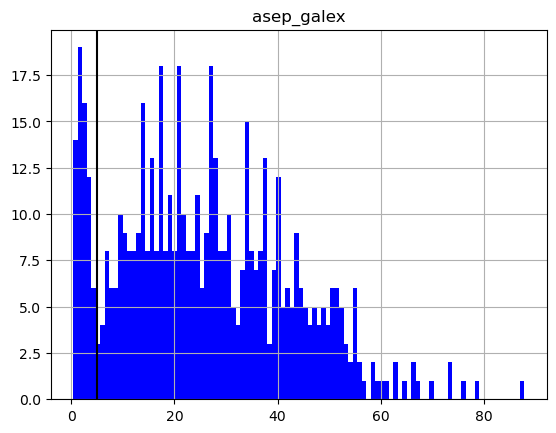

In [24]:
df.hist("asep_galex",bins=100,color="b")
plt.axvline(5,c="k")

array([[<AxesSubplot: title={'center': 'asep_kids'}>]], dtype=object)

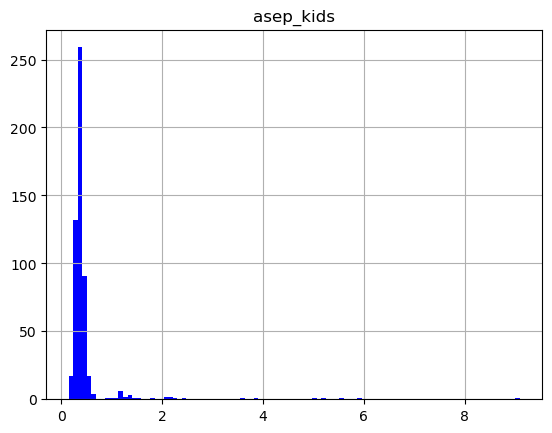

In [25]:
df.hist("asep_kids",bins=100,color='b')

# Save into output file h5

In [26]:
hf_outfile =  h5py.File(output_file_h5, 'w') 

In [27]:
for idx,row in df.iterrows():
    #print(idx,key_tags[idx])
    tag = key_tags[idx]
    h5group_out = hf_outfile.create_group(tag)
    
    wl = all_df[idx]["wl"].values
    fl = all_df[idx]["fl"].values
    
    parameter_names = list(row.index)
    parameter_values   =row.values
    
    if idx==0:
        print(parameter_names)
    
    for name,val in zip(parameter_names,parameter_values):
        h5group_out.attrs[name] = val
    
    d = h5group_out.create_dataset("wl",data=wl,compression="gzip", compression_opts=9)
    d = h5group_out.create_dataset("fl",data=fl,compression="gzip", compression_opts=9)

['num', 'name', 'ra', 'dec', 'Rmag', 'redshift', 'lines', 'RT', 'RV', 'eRV', 'Nsp', 'ra_galex', 'dec_galex', 'fuv_mag', 'nuv_mag', 'fuv_magerr', 'nuv_magerr', 'fuv_flux', 'nuv_flux', 'fuv_fluxerr', 'nuv_fluxerr', 'asep_galex', 'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000', 'FLUX_RADIUS', 'CLASS_STAR', 'MAG_GAAP_u', 'MAG_GAAP_g', 'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z', 'MAG_GAAP_Y', 'MAG_GAAP_J', 'MAG_GAAP_H', 'MAG_GAAP_Ks', 'MAGERR_GAAP_u', 'MAGERR_GAAP_g', 'MAGERR_GAAP_r', 'MAGERR_GAAP_i', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y', 'MAGERR_GAAP_J', 'MAGERR_GAAP_H', 'MAGERR_GAAP_Ks', 'FLUX_GAAP_u', 'FLUXERR_GAAP_u', 'FLUX_GAAP_g', 'FLUXERR_GAAP_g', 'FLUX_GAAP_r', 'FLUXERR_GAAP_r', 'FLUX_GAAP_i', 'FLUXERR_GAAP_i', 'FLUX_GAAP_Z', 'FLUXERR_GAAP_Z', 'FLUX_GAAP_Y', 'FLUXERR_GAAP_Y', 'FLUX_GAAP_J', 'FLUXERR_GAAP_J', 'FLUX_GAAP_H', 'FLUXERR_GAAP_H', 'FLUX_GAAP_Ks', 'FLUXERR_GAAP_Ks', 'Z_B', 'Z_ML', 'EXTINCTION_u', 'EXTINCTION_g', 'EXTINCTION_r', 'EXTINCTION_i', 'asep_kids', 'Delta_ZB', 'Delta_ZML', 'z_se

In [28]:
hf_outfile.keys()

<KeysViewHDF5 ['SPEC102', 'SPEC106', 'SPEC107', 'SPEC109', 'SPEC110', 'SPEC111', 'SPEC112', 'SPEC113', 'SPEC114', 'SPEC115', 'SPEC117', 'SPEC118', 'SPEC120', 'SPEC121', 'SPEC123', 'SPEC127', 'SPEC128', 'SPEC13', 'SPEC132', 'SPEC134', 'SPEC135', 'SPEC137', 'SPEC138', 'SPEC141', 'SPEC149', 'SPEC151', 'SPEC152', 'SPEC156', 'SPEC160', 'SPEC161', 'SPEC164', 'SPEC171', 'SPEC178', 'SPEC179', 'SPEC181', 'SPEC182', 'SPEC183', 'SPEC184', 'SPEC185', 'SPEC186', 'SPEC187', 'SPEC188', 'SPEC189', 'SPEC19', 'SPEC191', 'SPEC192', 'SPEC193', 'SPEC194', 'SPEC196', 'SPEC197', 'SPEC198', 'SPEC2', 'SPEC204', 'SPEC205', 'SPEC210', 'SPEC214', 'SPEC218', 'SPEC221', 'SPEC222', 'SPEC223', 'SPEC226', 'SPEC227', 'SPEC231', 'SPEC233', 'SPEC234', 'SPEC235', 'SPEC236', 'SPEC237', 'SPEC238', 'SPEC24', 'SPEC240', 'SPEC242', 'SPEC243', 'SPEC244', 'SPEC245', 'SPEC246', 'SPEC248', 'SPEC249', 'SPEC25', 'SPEC250', 'SPEC252', 'SPEC253', 'SPEC258', 'SPEC259', 'SPEC260', 'SPEC261', 'SPEC262', 'SPEC264', 'SPEC265', 'SPEC266', '

In [29]:
hf_outfile.close() 